In [2]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Loading Data
f = open("db_dump_new_files.json")
data = json.load(f)
df = pd.json_normalize(data)

#hacky solution to remove the panda-appended user_. entry
renamed= [name.split("_.")[-1] for name in df.columns]
col_rename = {i:j for i,j in zip(df.columns,renamed)}
df = df.rename(columns=col_rename)

In [4]:
def createSubDFs(df):
    profiling_df = df[['user_profiling_age', 'user_profiling_position',
        'user_profiling_useOfDP', 'user_profiling_useOfAI',
        'user_profiling_useOfAI_details', 'user_profiling_mlFamiliarity']]

    cf_df = df[[ 'counterfactuals_twoAxisCounterfactuals_image0_understandability',
        'counterfactuals_twoAxisCounterfactuals_image0_usability',
        'counterfactuals_twoAxisCounterfactuals_image0_informativeness',
        'counterfactuals_twoAxisCounterfactuals_image0_value',
        'counterfactuals_prototypeInterpolation_image0_understandability',
        'counterfactuals_prototypeInterpolation_image0_usability',
        'counterfactuals_prototypeInterpolation_image0_informativeness',
        'counterfactuals_prototypeInterpolation_image0_value']]

    ca_df = df[['conceptAttribution_textAttributes_image0_understandability',
        'conceptAttribution_textAttributes_image0_usability',
        'conceptAttribution_textAttributes_image0_informativeness',
        'conceptAttribution_textAttributes_image0_value',
        'conceptAttribution_textAttributes_comments']]

    prototypes_df = df[['prototypes_prototypes_image0_understandability',
        'prototypes_prototypes_image0_usability',
        'prototypes_prototypes_image0_informativeness',
        'prototypes_prototypes_image0_value']]

    trust_df = df[['trustScores_borderlineCases_image0_understandability',
        'trustScores_borderlineCases_image0_usability',
        'trustScores_borderlineCases_image0_value',
        'trustScores_borderlineCases_image0_informativeness',
        'trustScores_borderlineCases_comments']]

    cf_df = df[['counterfactuals_twoAxisCounterfactuals_image0_understandability',
        'counterfactuals_twoAxisCounterfactuals_image0_usability',
        'counterfactuals_twoAxisCounterfactuals_image0_informativeness',
        'counterfactuals_twoAxisCounterfactuals_image0_value',
        'counterfactuals_prototypeInterpolation_image0_understandability',
        'counterfactuals_prototypeInterpolation_image0_usability',
        'counterfactuals_prototypeInterpolation_image0_informativeness',
        'counterfactuals_prototypeInterpolation_image0_value']]
    return profiling_df,cf_df,ca_df,prototypes_df,trust_df,cf_df

In [7]:
#remove NaN columns
df = df.dropna()

#get column values while dropping individual NaNs for debugging purposes
# test_data = df["user_profiling_useOfDP"]
# test_data = test_data.dropna().unique().tolist()

#select subdfs grouped by column for easier handling
profiling_df,cf_df,ca_df,prototypes_df,trust_df,cf_df = createSubDFs(df)


count               2
unique              1
top       in research
freq                2
Name: user_profiling_useOfDP, dtype: object


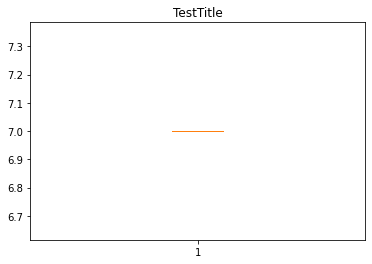

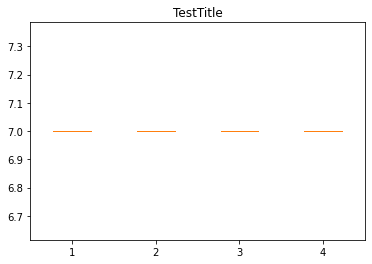

In [9]:

#function to plot a column
def boxPlot(data,title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.boxplot(data)

boxPlot(prototypes_df.iloc[0],"TestTitle")

#and the full subdf
def boxPlotDF(sub_df,title):
    #throw out non-numeric data
    int_df = sub_df.select_dtypes(include="int64")
    data = int_df.values
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.boxplot(data)

boxPlotDF(prototypes_df,"TestTitle")

#function to get most relevant statistical measures for single column
def descriptiveStatistics(column):
    print(df[column].describe())

descriptiveStatistics("user_profiling_useOfDP")